+ https://www.kaggle.com/puneet6060/intel-image-classification

In [41]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [42]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [43]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

In [59]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        }

#데이터를 불러오는 경로를 설정

data_dir='./archive'
#tip : os는 os에서 사용하는 명령어를 그대로 불러올 수 있음
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x])
                 for x in ['train', 'test']}

#데이터로더를 불러오는 설정

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4,
                                             shuffle = True, num_workers=0)
                for x in ['train', 'test']}

dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


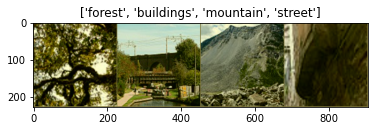

In [60]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.225])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
#학습 데이터의 배치를 얻는 과정
inputs, classes = next(iter(dataloaders['train']))

#배치로부터 격자 형태의 grid를 만드는 과정
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [61]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 100):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0   #0.0으로 하면 자동으로 float / 0으로 하면 자동으로 int로 저장됨
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)
        
        for phase in ['train', 'val']: # phase에 따라 실행방법이 변경되게 되는데, phase가 train이라면, train을
            if phase == 'train':       # train이 아닐경우 ('val'을 의미) val으로 실행
                model.train()
            else:
                model.eval()
                running_loss = 0.0
                running_corrects = 0
                
                for inputs, labels in dataloaders[phase]:
                    #inputs = inputs.to(device)
                    #labels = labels.to(device)
                    
                    optimizer.zero_grad()
                    
                    #순전파 과정
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        #학습 단계인 경우는 역전파 + 최적화 과정을 거치게 됨
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print('{} Loss: {:.4f} ACC: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())   #state_dict : 전이함수

                print()

            time_elapsed = time.time() - since
            print('Training comoplete in {:.0f}s'.format(
                  time_elapsed // 60, time_elapsed % 60))
            print('Best val Acc: {:4f}'.format(best_acc))
            
            model.load_state_dict(best_model_wts)
            return model

In [66]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [67]:
model_ft = models.resnet18(pretrained=True)   #resnet18의 가중치를 가져오는 구조
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)  #출력 샘플의 크기는 2로 설정

criterion = nn.CrossEntropyLoss()

#매개변수들이 최적화가 잘 되어있는지 살펴보기
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9)

# 에폭이 7 증가할 때마다 학습률 0.1씩 감소시킴
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [68]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 100)

Epoch 0/99
----------
Training comoplete in 0s
Best val Acc: 0.000000


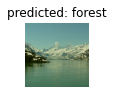

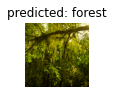

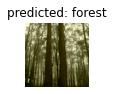

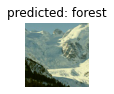

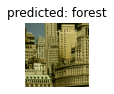

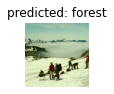

In [69]:
visualize_model(model_ft)

In [70]:
model_conv = torchvision.models.resnet18(pretrained=True)
for parm in model_conv.parameters():
    parm.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

#model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01,momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.01)

In [71]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Training comoplete in 0s
Best val Acc: 0.000000


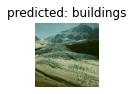

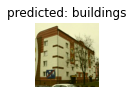

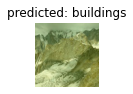

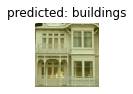

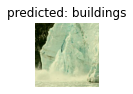

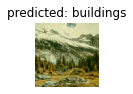

In [72]:
visualize_model(model_conv)

plt.ioff()   #ioff : 그림과 관련된 모든 함수를 실행
plt.show()

## ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ